In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


test_data_dir = "chest_xray/test"
model_name = "pneumonia_3.h5"

# 画像サイズの設定
img_height, img_width = 150, 150

# 分類カテゴリ名の設定、学習時と同じ順番にする
classes = ['NORMAL','PNEUMONIA']
nb_classes = len(classes)

# 評価用（テスト用）データセットの準備
test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

# ジェネレータを生成
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size = (img_height, img_width),
        classes = classes,
        batch_size = 1,
        class_mode = 'categorical',
        shuffle=False)

# 正解ラベル（健康=0、肺炎=1）のOne-hotベクトルを取得
y_true = to_categorical(test_generator.labels, nb_classes)

# ファインチューニングしたCNNモデルのロード
model = tf.keras.models.load_model(model_name)

# テストデータに対する予測
y_pred = model.predict(test_generator, verbose=1)
print(y_pred)


Found 624 images belonging to 2 classes.
624/624 [==============================] - 8s 7ms/step
[[9.9926895e-01 7.3107611e-04]
 [9.9682069e-01 3.1792934e-03]
 [9.9839729e-01 1.6027229e-03]
 ...
 [5.8151467e-04 9.9941850e-01]
 [2.7853163e-04 9.9972147e-01]
 [3.2724399e-02 9.6727562e-01]]


[NORMAL]
Accuracy 0.934, Precision 0.941, Recall 0.880, Specificity 0.967, F1 0.909
AUC: 0.924, AP: 0.873


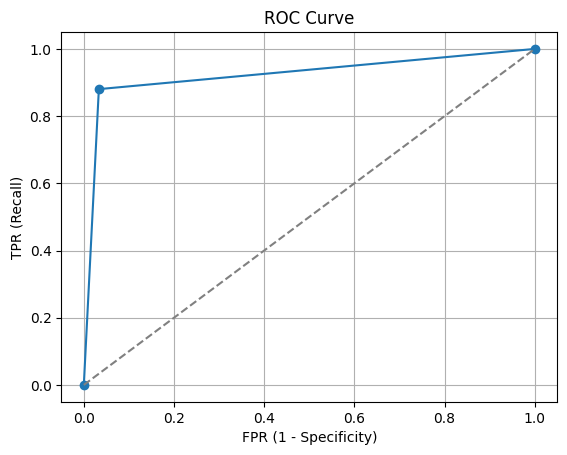

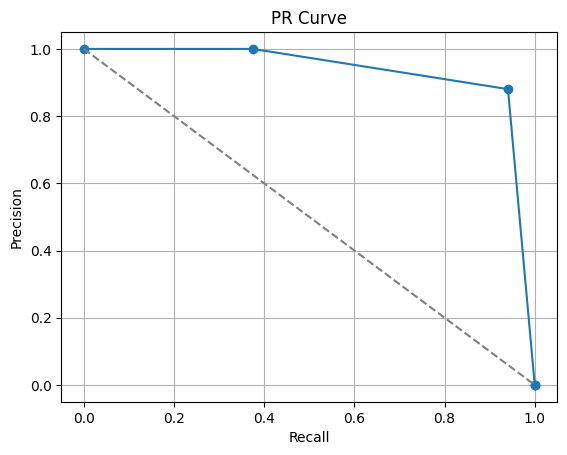

<Figure size 640x480 with 0 Axes>

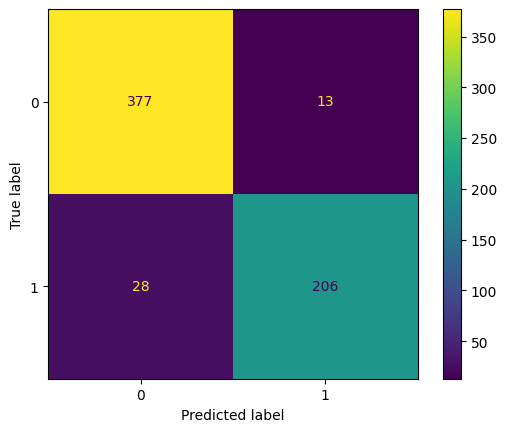

[PNEUMONIA]
Accuracy 0.934, Precision 0.931, Recall 0.967, Specificity 0.880, F1 0.948
AUC: 0.924, AP: 0.921


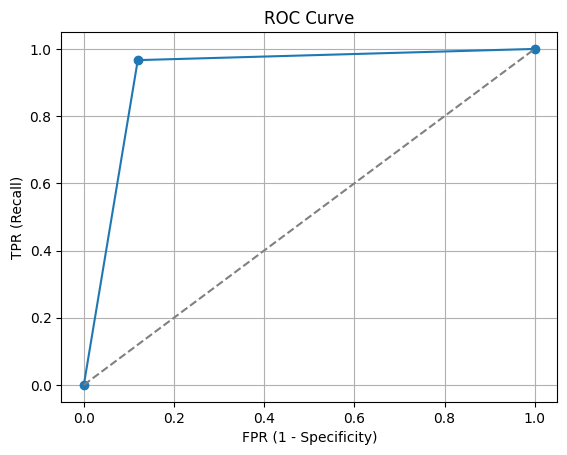

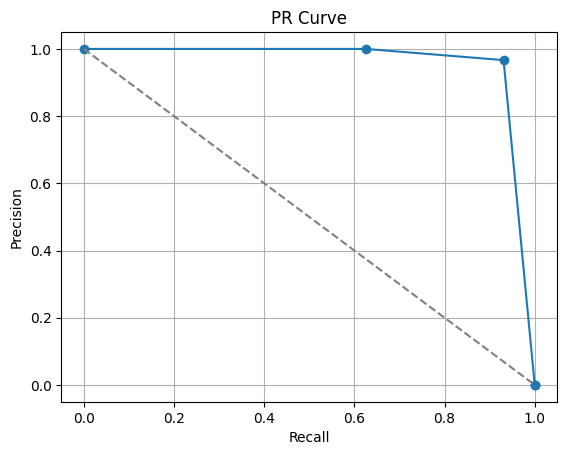

<Figure size 640x480 with 0 Axes>

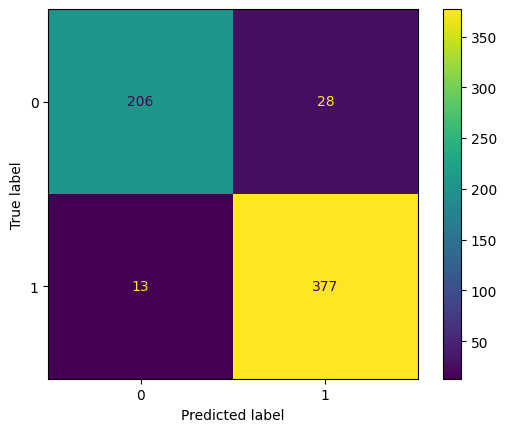

---
pneumonia_3.h5 - Macro F1 Score: 0.929, Macro AUC: 0.924, Macro AP: 0.897


<Figure size 640x480 with 0 Axes>

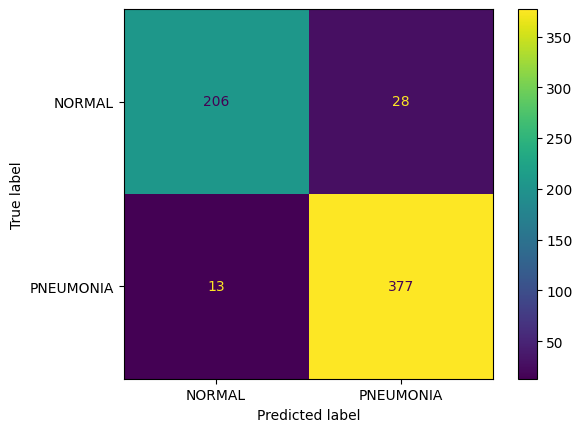

In [2]:
sum_f1 = 0.0
sum_auc = 0.0
sum_ap = 0.0

# クラスごとに評価
THRESH = 0.5
for i in range(nb_classes):
    # 特定クラスの予測結果のみを取得
    p = y_pred[:, i]
    p_prob = p[:]       # ROC曲線、PR曲線用に配列をコピー
    gt = y_true[:, i]

    # 予測結果のしきい値処理
    p[p >= THRESH] = 1
    p[p < THRESH] = 0

    # 二値混同行列
    cf = metrics.confusion_matrix(gt, p)

    # TP, TN, FP, FNの取得
    tn, fp, fn, tp = cf.ravel()

    # 各評価指標の計算
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = (2 * precision * recall) / (precision + recall)
    sum_f1 += f1

    print(f"[{classes[i]}]\nAccuracy {acc:.3f}, Precision {precision:.3f}, Recall {recall:.3f}, Specificity {specificity:.3f}, F1 {f1:.3f}")

    # AUCとAP
    auc = metrics.roc_auc_score(gt, p_prob)
    ap = metrics.average_precision_score(gt, p_prob)
    print(f"AUC: {auc:.3f}, AP: {ap:.3f}")
    sum_auc += auc
    sum_ap += ap

    # ROC曲線
    fpr, tpr, thresholds = metrics.roc_curve(gt, p_prob)
    plt.plot(fpr, tpr, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("FPR (1 - Specificity)")
    plt.ylabel("TPR (Recall)")
    plt.grid()
    plt.show()
    plt.clf()

    # PR曲線
    recalls, precisions, thresholds = metrics.precision_recall_curve(gt, p_prob)
    recalls = np.insert(recalls, 0, 0.0)
    recalls = np.append(recalls, 1.0)
    precisions = np.insert(precisions, 0, 1.0)
    precisions = np.append(precisions, 0.0)
    plt.plot(recalls, precisions, marker="o")
    plt.plot([0, 1], [precisions[0], precisions[-1]], linestyle="--", color="gray")
    plt.title("PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.show()
    plt.clf()

    # 混同行列の表示
    cf_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cf)
    cf_disp.plot()
    plt.show()
    plt.clf()

# macro平均    
macro_f1 = sum_f1 / nb_classes
macro_auc = sum_auc / nb_classes
macro_ap = sum_ap / nb_classes
print(f"---\n{model_name} - Macro F1 Score: {macro_f1:.3f}, Macro AUC: {macro_auc:.3f}, Macro AP: {macro_ap:.3f}")

# 多クラス混同行列
yp = np.argmax(y_pred, axis=1)
yt = np.argmax(y_true, axis=1)
cf_all = metrics.confusion_matrix(yt, yp)
cf_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cf_all, display_labels=classes)
cf_disp.plot()
plt.show()